In [96]:
%%html
<style>
#notebook-container {
    width: 90%;
    background-color: #EEE
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .output_wrapper {
    width: 50%;
    background-color: #FFF
}

.code_cell .input {
    width: 50%;
    background-color: #FFF
}
</style>

In [131]:
clear all
A = [ 0 1 0; 0 0 1; -2 -4 -3];
B = [0 0; 0 1; 1 0];
C = [1 0 0; 0 1 0];
ST = 0.1;
sys = ss(A,B,C,[]);
sysd = c2d(sys,ST)


sysd =
 
  A = 
              x1         x2         x3
   x1     0.9997    0.09937    0.00452
   x2  -0.009041     0.9816    0.08581
   x3    -0.1716    -0.3523     0.7242
 
  B = 
              u1         u2
   x1  0.0001546   0.004984
   x2    0.00452    0.09937
   x3    0.08581   -0.01839
 
  C = 
       x1  x2  x3
   y1   1   0   0
   y2   0   1   0
 
  D = 
       u1  u2
   y1   0   0
   y2   0   0
 
サンプル時間:  0.1 seconds
離散時間状態空間モデル。




## 拡大系を組む

4サンプルをひとまとめとして拡大系を組む。
極が早すぎると失敗したりする…

In [132]:
% Extended system
A_ = sysd.A^4;
c1 = sysd.C(1,:); c2 = sysd.C(2,:);
C_= [c1;c2;c2*sysd.A^2];

In [133]:
P = [-1 -1.5 -2];
%P = [-2 -3 -4];
K_ = place(A_',C_',exp(P*ST*4))'
k1 = K_(:,1); k21 = K_(:,2); k22 = K_(:,3);


K_ =

    0.3258    0.0297    0.3616
   -0.0594   -1.1023    1.4222
   -0.4834    0.9801   -2.0574




kゲインの変換を行う

In [134]:
W4 = sysd.A';
W3 = sysd.A'*W4 - c2'*k22';
W2 = sysd.A'*W3;
% conversion
k1_ = inv(W2)'*k1
k21_ = inv(W2)'*k21
k22_ = inv(W4)'*k22


k1_ =

    0.3280
   -0.0077
   -0.7217


k21_ =

    0.1586
    1.7694
   -2.2920


k22_ =

    0.2092
    1.6257
   -2.0007




計算したkgainについて極を計算する。

In [135]:
log(eig(sysd.A*(sysd.A-[k1_ k21_]*sysd.C)*sysd.A*(sysd.A-[zeros(3,1) k22_]*sysd.C)))/ST



ans =

   -4.0000
   -8.0000
   -6.0000




In [28]:
sysd.C


ans =

     1     0     0
     0     1     0




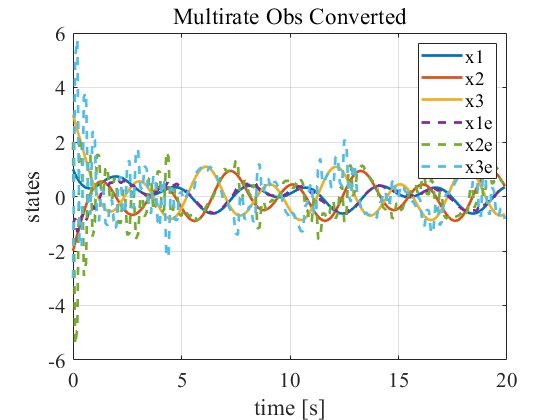

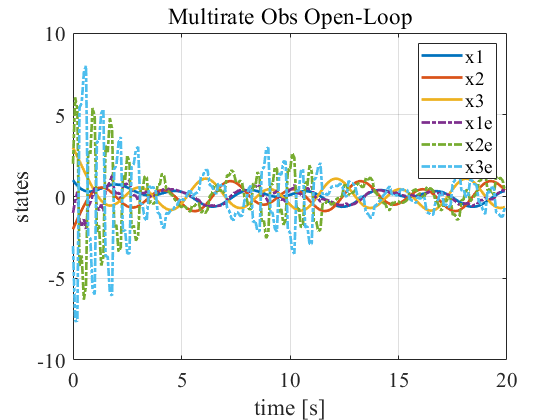

In [136]:
%% with noise
Kreg = place(sysd.A,sysd.B,exp(ST*[-1,-1,-0.5]));
Kreg = zeros(2,3);
% sim setting
len = 200;
time = 0:ST:ST*(len-1);
x_gt = zeros(3,len);
x_obs = zeros(3,len); 
x_obs2 = zeros(3,len);

% noise variable 
sigma1 = 0.1;
sigma2 = 0.2;
Noise = [sigma1;sigma2] .* randn(2,len);

% init
x_gt(:,1) = [1;-2;3];
x_obs(:,1) = [-1;2;-3]; % converted 
x_obs2(:,1) = [-1;2;-3]; % Non-converted
u1 = sin(1*pi/3*time);
u2 = sin(2*pi/3*time);
U = [u1;u2];

for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i-1)+Noise(:,i-1);
    % Observation
    if mod(i,4) == 2
        x_obs_hat = sysd.A * x_obs(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        x_obs2_hat = sysd.A * x_obs2(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs_hat = sysd.C * x_obs(:,i-1);
        yobs2_hat = sysd.C * x_obs2(:,i-1);
        x_obs(:,i) = x_obs_hat + [k1_ k21_]*(y-yobs_hat);
        x_obs2(:,i) = x_obs2_hat + [k1 k21]*(y-yobs2_hat);                
    elseif mod(i,4) == 0
        x_obs_hat = sysd.A * x_obs(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        x_obs2_hat = sysd.A * x_obs2(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs_hat = sysd.C * x_obs(:,i-1);
        yobs2_hat = sysd.C * x_obs2(:,i-1);
        x_obs(:,i) = x_obs_hat + [zeros(3,1) k22_]*(y-yobs_hat);
        x_obs2(:,i) = x_obs2_hat + [zeros(3,1) k22]*(y-yobs2_hat);
    else
        x_obs(:,i) = sysd.A * x_obs(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        x_obs2(:,i) = sysd.A * x_obs2(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    end   
end

fig = figure;
plot(time,x_gt,time,x_obs2,'-.')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Multirate Obs Open-Loop')
grid on
xlabel('time [s]')
ylabel('states')

fig = figure;
plot(time,x_gt,time,x_obs,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Multirate Obs Converted')
grid on
xlabel('time [s]')
ylabel('states')


In [138]:
Knom3 = place(A_',sysd.C',exp(ST*4*P))';
Knom4 = place((sysd.A')^2,sysd.C',exp(ST*2*P))';
Knom5 = place(sysd.A',sysd.C',exp(ST*P))';

P_obs3 = zeros(3,3,len);
P_obs4 = zeros(3,3,len);
P_obs5 = zeros(3,3,len);


x_obs3 = zeros(3,len);
x_obs3(:,1) = [-1;2;-3]; % without multirate
x_obs4 = zeros(3,len);
x_obs4(:,1) = [-1;2;-3]; % without multirate
x_obs5 = zeros(3,len);
x_obs5(:,1) = [-1;2;-3]; % without multirate


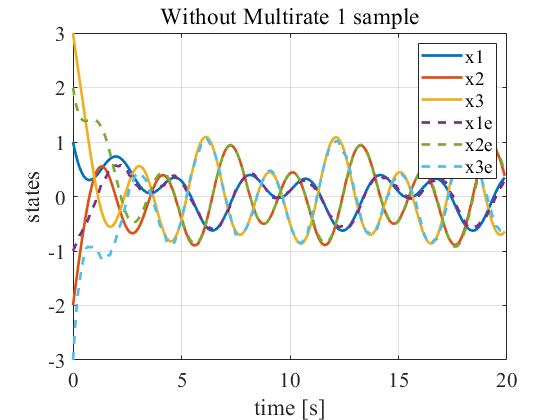

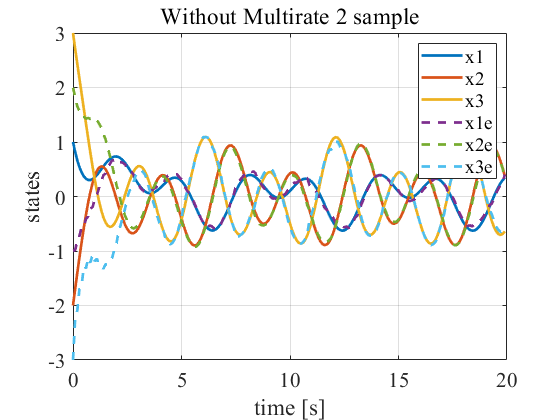

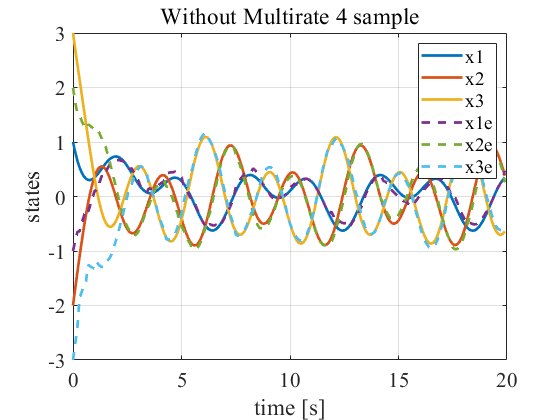

In [155]:
%% observer style
Knom3 = place(A_',sysd.C',exp(ST*4*P))';
Knom4 = place((sysd.A')^2,sysd.C',exp(ST*2*P))';
Knom5 = place(sysd.A',sysd.C',exp(ST*P))';

P_obs3 = zeros(3,3,len);
P_obs4 = zeros(3,3,len);
P_obs5 = zeros(3,3,len);
W = diag([sigma1^2,sigma2^2]);


x_obs3 = zeros(3,len);
x_obs3(:,1) = [-1;2;-3]; % without multirate
x_obs4 = zeros(3,len);
x_obs4(:,1) = [-1;2;-3]; % without multirate
x_obs5 = zeros(3,len);
x_obs5(:,1) = [-1;2;-3]; % without multirate

for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i-1)+Noise(:,i-1);
    % Observation
    if mod(i,4) == 0
        x_obs3_hat = sysd.A * x_obs3(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs3_hat = sysd.C * x_obs3(:,i-1);
        x_obs3(:,i) = x_obs3_hat + Knom3*(y-yobs3_hat);
        P_obs3(:,:,i) = (eye(3)-Knom3*sysd.C)*sysd.A*P_obs3(:,:,i-1)*sysd.A'*(eye(3)-Knom3*sysd.C)'+Knom3*W*Knom3';
        x_obs4_hat = sysd.A * x_obs4(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs4_hat = sysd.C * x_obs4(:,i-1);
        x_obs4(:,i) = x_obs4_hat + Knom4*(y-yobs4_hat);                

    elseif mod(i,2) == 0
        x_obs3(:,i) = sysd.A * x_obs3(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        P_obs3(:,:,i) = sysd.A*P_obs3(:,:,i-1)*sysd.A';
        x_obs4_hat = sysd.A * x_obs4(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs4_hat = sysd.C * x_obs4(:,i-1);
        x_obs4(:,i) = x_obs4_hat + Knom4*(y-yobs4_hat);                
    else
        x_obs3(:,i) = sysd.A * x_obs3(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        P_obs3(:,:,i) = sysd.A*P_obs3(:,:,i-1)*sysd.A';
        x_obs4(:,i) = sysd.A * x_obs4(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    end
    x_obs5_hat = sysd.A * x_obs5(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    yobs5_hat = sysd.C * x_obs5(:,i-1);
    x_obs5(:,i) = x_obs5_hat + Knom5*(y-yobs5_hat);
end

fig=figure;
plot(time,x_gt,time,x_obs3,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Without Multirate 4 sample')
grid on
xlabel('time [s]')
ylabel('states')

fig=figure;
plot(time,x_gt,time,x_obs4,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Without Multirate 2 sample')
grid on
xlabel('time [s]')
ylabel('states')

fig=figure;
plot(time,x_gt,time,x_obs5,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Without Multirate 1 sample')
grid on
xlabel('time [s]')
ylabel('states')


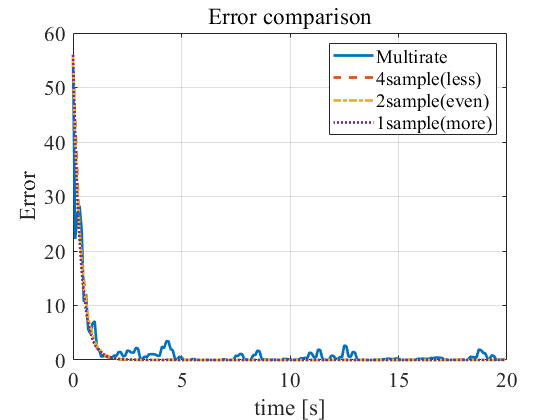

In [143]:
figure
plot(time',diag((x_gt-x_obs)'*(x_gt-x_obs)),time',diag((x_gt-x_obs3)'*(x_gt-x_obs3)),'--',time',diag((x_gt-x_obs4)'*(x_gt-x_obs4)),'-.',time',diag((x_gt-x_obs5)'*(x_gt-x_obs5)),':')
grid on
title('Error comparison')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')
ylabel('Error')

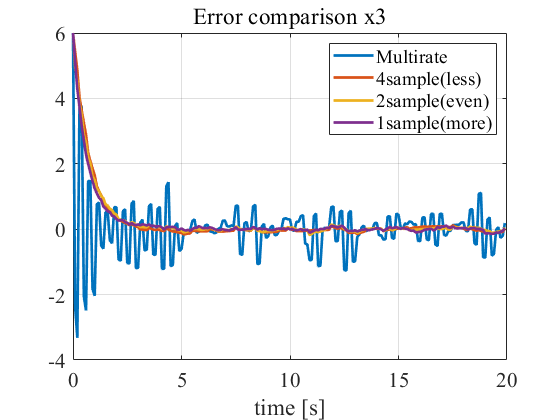

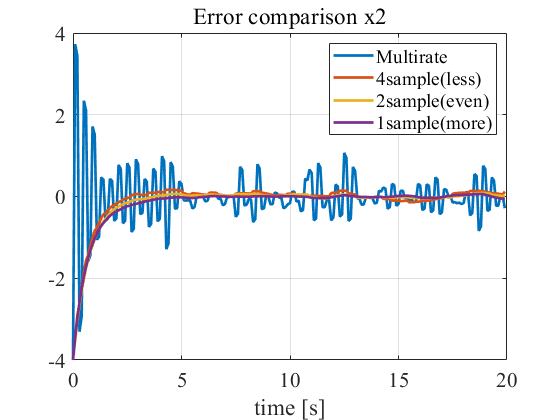

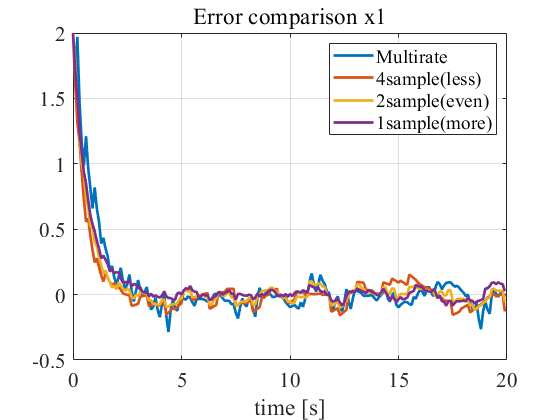

In [144]:
%% errors

e_obs = (x_gt-x_obs);
e_obs3 = (x_gt-x_obs3);
e_obs4 = (x_gt-x_obs4);
e_obs5 = (x_gt-x_obs5);

figure
plot(time',e_obs(1,:),time',e_obs3(1,:),time',e_obs4(1,:),time',e_obs5(1,:))
grid on
title('Error comparison x1')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

figure
plot(time',e_obs(2,:),time',e_obs3(2,:),time',e_obs4(2,:),time',e_obs5(2,:))
grid on
title('Error comparison x2')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

figure
plot(time',e_obs(3,:),time',e_obs3(3,:),time',e_obs4(3,:),time',e_obs5(3,:))
grid on
title('Error comparison x3')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

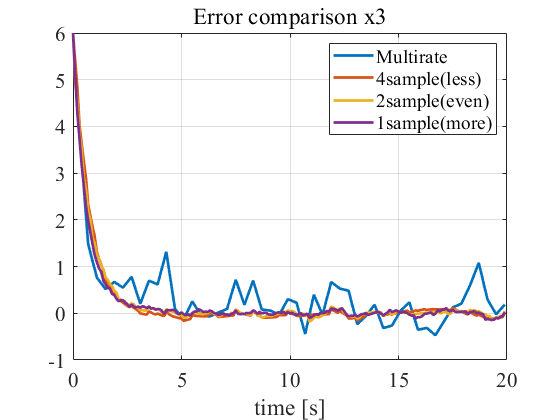

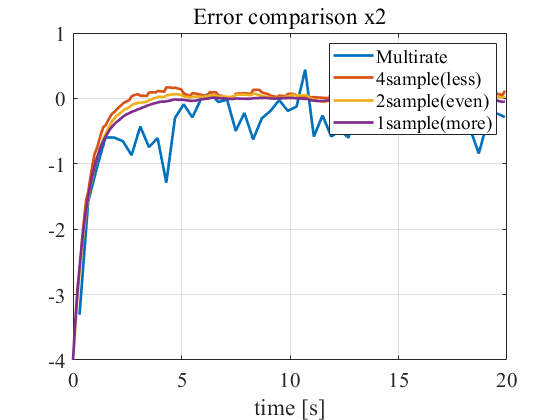

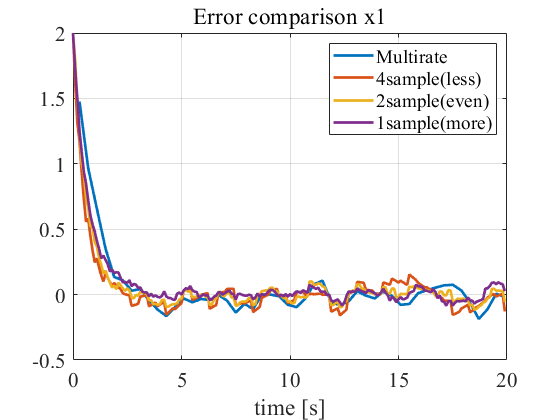

In [145]:
time_ = [];
e_obs_ = [];
for i=1:len
    if mod(i,4)==0
        time_ = [time_;time(i)];
        e_obs_ = [e_obs_,e_obs(:,i)];
    end
end

figure
plot(time_,e_obs_(1,:),time',e_obs3(1,:),time',e_obs4(1,:),time',e_obs5(1,:))
grid on
title('Error comparison x1')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

figure
plot(time_,e_obs_(2,:),time',e_obs3(2,:),time',e_obs4(2,:),time',e_obs5(2,:))
grid on
title('Error comparison x2')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

figure
plot(time_,e_obs_(3,:),time',e_obs3(3,:),time',e_obs4(3,:),time',e_obs5(3,:))
grid on
title('Error comparison x3')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

In [147]:
cov(e_obs3(1,100:end)')
cov(e_obs4(1,100:end)')
cov(e_obs5(1,100:end)')
W = diag([sigma1^2,sigma2^2]);

Cnom3=Knom3*W*Knom3';
Pend3 = sylvester(inv(A_-Knom3*sysd.C),(A_-Knom3*sysd.C)',(A_-Knom3*sysd.C)\Cnom3)
Cnom4=Knom4*W*Knom4';
Pend4 = sylvester(inv(sys.A^2-Knom4*sysd.C),(sys.A^2-Knom4*sysd.C)',(sys.A^2-Knom4*sysd.C)\Cnom4)
Cnom5=Knom5*W*Knom5';
Pend5 = sylvester(inv(sys.A-Knom5*sysd.C),(sys.A-Knom5*sysd.C)',(sys.A-Knom5*sysd.C)\Cnom5)



ans =

    0.0061


ans =

    0.0026


ans =

    0.0020


Pend3 =

    0.0037   -0.0018   -0.0034
   -0.0018    0.0006    0.0020
   -0.0034    0.0020    0.0028


Pend4 =

    0.0005   -0.0008    0.0008
   -0.0008    0.0013   -0.0014
    0.0008   -0.0014    0.0012


Pend5 =

   1.0e-03 *

    0.3232   -0.2560   -0.0958
   -0.2560    0.1604    0.1671
   -0.0958    0.1671   -0.1446




In [156]:
Pend3_ = P_obs3(:,:,end)



Pend3_ =

    0.0071   -0.0064   -0.0021
   -0.0064    0.0078   -0.0012
   -0.0021   -0.0012    0.0054




In [ ]:
% check pole
log(eig(A_-Knom3*sysd.C))/ST/4
log(eig(sysd.A^2-Knom4*sysd.C))/ST/2
log(eig(sysd.A-Knom5*sysd.C))/ST